# SQL vs NoSql vs NewSql

This notebook is used to run code and generate graphs

### Config

In [1]:
num_of_runs = 3

### Imports

In [2]:
import subprocess
import os
import time
import re
import postgres_import as pos_i
import mysql_import as my_i
import memsql_import as mem_i
import random

### Helper function to generate a bar plot graph

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def bar_plot(data, items, colours, title):
    fig = plt.figure()
    fig.set_size_inches(15, 7)

    width = .45
    ind = np.arange(len(data))
    
    plt.bar(0.3+ind, data, width=width, color=colours)
    plt.xticks(0.3+ind, items)
    plt.title(title)

    fig.autofmt_xdate()

    plt.show()

### Helper function to run commands inside a shell

In [4]:
def run_command(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

def run_command2(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

## Starting all the docker containers to check if it's all right

In [5]:
_ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d')

mysql is up-to-date
orientdb is up-to-date
cassandra is up-to-date
nuodb is up-to-date
redis is up-to-date
cockroach is up-to-date
trafodion is up-to-date
postgres is up-to-date
neo4j is up-to-date
mongo is up-to-date
voltdb is up-to-date
memsql is up-to-date



## Stopping all the containers
Test functions will start and stop the containers many times in order to accurately measure times.

In [6]:
_ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down')

Stopping voltdb ... 
Stopping memsql ... 
Stopping neo4j ... 
Stopping mongo ... 
Stopping trafodion ... 
Stopping cockroach ... 
Stopping cassandra ... 
Stopping postgres ... 
Stopping mysql ... 
Stopping redis ... 
Stopping orientdb ... 
Stopping nuodb ... 
Stopping nuodb ... doneStopping postgres ... doneStopping mongo ... doneStopping voltdb ... doneStopping cockroach ... doneStopping neo4j ... doneStopping redis ... doneStopping mysql ... doneStopping orientdb ... doneStopping cassandra ... doneStopping trafodion ... doneStopping memsql ... doneRemoving voltdb ... 
Removing memsql ... 
Removing neo4j ... 
Removing mongo ... 
Removing trafodion ... 
Removing cockroach ... 
Removing cassandra ... 
Removing postgres ... 
Removing mysql ... 
Removing redis ... 
Removing orientdb ... 
Removing nuodb ... 
Removing mongo ... doneRemoving voltdb ... doneRemoving mysql ... doneRemoving orientdb ... doneRemoving memsql ... doneRemoving cockroach ... doneRemoving redis ... doneRemoving neo4j

## Definitions

In [7]:
postgres_container = "postgres"
containers = ["mongo", "redis", "neo4j", "orientdb", "cassandra", postgres_container, "mysql", "memsql", "voltdb", "cockroach"]
colours = ["lightgreen", "red", "deepskyblue", "orange", "skyblue", "lightsteelblue", "steelblue", "cornflowerblue", "firebrick", "darkgreen"]

### Helper functions to run tests and measure the time taken

In [10]:
def exec_and_time(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == postgres_container or container == "mysql" or container == "memsql":
        command[0](os.path.join(os.path.abspath('./Docker/shared_data'),command[1]))
    elif container == "cockroach":
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command[0] + '"', verbose, save_mem)
        _ = run_command('docker exec --privileged --user postgres '+ postgres_container +' sh -c "' + command[1] + '"', verbose, save_mem)
    elif container == "cassandra":
        _ = run_command2('docker exec --privileged ' + container + ' '+ command[0] +' -c "' + command[1] + '"', verbose, save_mem)
    else: 
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command + '"', verbose, save_mem)
    end = time.time()
    return end - start

In [42]:
def average_time(commands, containers, iterations, verbose=True, import_data=False):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
                
            coackroach_ip = ""
            
            app1 = data_import_commands[i]
            app2 = commands[i]
            
            if containers[i] == "cockroach":
                ip = run_command('docker exec cockroach ip route', verbose=False)
                ip = ip[len(ip)-2].split(" ")
                ip = ip[len(ip)-2]
                cockroach_ip = ip
                print(cockroach_ip)
                app1 = data_import_commands[i]
                app2 = commands[i]
                data_import_commands[i][1] = data_import_commands[i][1].replace("{{cockroach_ip}}", cockroach_ip)
                commands[i][1].replace("{{coackroach_ip}}", coackroach_ip)
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
                
            data_import_commands[i] = app1
            commands[i] = app2
            
            time_taken = exec_and_time(containers[i], commands[i], verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

## Average bulk import time

### Import commands

In [39]:
data_import_commands = [
    "mongoimport --db testing_db --collection customers --type csv --headerline --file /shared_data/mock_data_10000_rows.csv && mongo testing_db --eval 'db.customers.createIndex({Id:1});'",
    "cat /shared_data/mock_data_10000_rows2.csv | redis-cli --pipe",
    "cp /shared_data/mock_data_10000_neo.csv /var/lib/neo4j/import && cat /shared_scripts/import_mock_10000.cypher | /var/lib/neo4j/bin/cypher-shell",
    "/orientdb/bin/oetl.sh /shared_scripts/import_orient_10000.json",
    ["bash", "cqlsh -f /shared_scripts/import_mock_10000.cql"],
    [pos_i.sql_import, "mock_data_10000_rows_utf8.csv"], #postgres
    [my_i.sql_import, "mock_data_10000_rows_utf8.csv"], #mysql
    [mem_i.sql_import, "mock_data_10000_rows_utf8.csv"], #memsql
    "cat /shared_scripts/import_voltdb.sql | sqlcmd && /opt/voltdb/bin/csvloader customers -f /shared_data/mock_data_10000_rows.csv",
    ["./cockroach sql --insecure --execute='create database if not exists mock;'", "psql -p 26257 -h {{cockroach_ip}} -d mock -U root < /shared_data/postgres_dump.sql"]
]

#### Iterating

In [40]:
(import_times_avg, import_times_peak) = average_time(data_import_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
172.18.0.2
mongo: 1.6690561771392822
redis: 0.2510030269622803
neo4j: 5.477948427200317
orientdb: 14.5785653591156
cassandra: 4.415853023529053
postgres: 4.567066192626953
mysql: 1.3113808631896973
memsql: 3.6654417514801025
voltdb: 6.135500192642212
cockroach: 2.1788086891174316


### Results

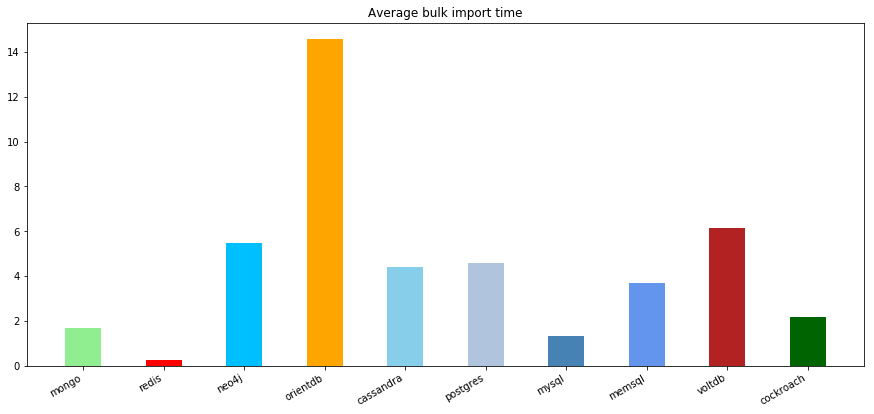

In [41]:
bar_plot(import_times_avg, containers, colours, "Average bulk import time")

## Query execution time and throughput

### Helper functions, modified from the previous ones
And also dependant from them.

In [15]:
def exec_and_time2(container, command, verbose=True, save_mem=False, long_output=False):
    start = time.time()
    if container == "cassandra" or long_output:
        _ = run_command2(command, verbose, save_mem)
    else:
        _ = run_command(command, verbose, save_mem)
    end = time.time()
    return end - start

In [46]:
def average_time2(commands, containers, iterations, verbose=True, import_data=True):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
                
            coackroach_ip = ""
            
            app1 = data_import_commands[i]
            app2 = commands[i]
            
            if containers[i] == "cockroach":
                ip = run_command('docker exec cockroach ip route', verbose=False)
                ip = ip[len(ip)-2].split(" ")
                ip = ip[len(ip)-2]
                cockroach_ip = ip
                data_import_commands[i][1] = data_import_commands[i][1].replace("{{cockroach_ip}}", cockroach_ip)
                print(data_import_commands[i])
            if import_data:
                if containers[i] == "redis":
                    exec_and_time2("redis", r"""docker exec --privileged redis sh -c "cat /shared_data/mock_data_10000_set.csv | redis-cli --pipe" """, verbose=False, save_mem=True)
                else: 
                    exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            if containers[i] == "neo4j":
                exec_and_time2("neo4j", r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n:Customer) CREATE (n)-[r:Autoedge]->(n) RETURN r;\" | /var/lib/neo4j/bin/cypher-shell" """, verbose=False, save_mem=True)
            
            data_import_commands[i] = app1
            commands[i] = app2
            
            time_taken = exec_and_time2(containers[i], commands[i].replace("{{id}}", str(random.randrange(0, 9999, 1))), verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        #_ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

### Unindexed Search Commands
Redis has no unindexed search.

In [47]:
unindexed_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({first_name:'Hosea'}).pretty().shellPrint();" """,
    "",
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n) WHERE n.firstName = 'Hosea' RETURN n;\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select from Customer where first_name = 'Hosea' " """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select * from customers where first_name = 'Hosea' allow filtering;" """,
    r"""docker exec --privileged postgres sh -c "echo \"SELECT * FROM customers WHERE first_name = 'Hosea'\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select * from customers where first_name = 'Hosea';\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; SELECT * FROM customers WHERE first_name = 'Hosea';" """ 
]

#### Iterating

In [48]:
(unindexed_read_times_avg, unindexed_read_times_peak) = average_time2(unindexed_read_commands, containers, num_of_runs)
unindexed_read_times_avg[1] = 0; # redis has no unindexed search

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
["./cockroach sql --insecure --execute='create database if not exists mock;'", 'psql -p 26257 -h 172.18.0.2 -d mock -U root < /shared_data/postgres_dump.sql']
mongo: 0.2069995403289795
redis: 0.009001731872558594
neo4j: 1.6419987678527832
orientdb: 3.328256607055664
cassandra: 0.7610006332397461
postgres: 0.20639920234680176
mysql: 0.1461167335510254
memsql: 0.523759126663208
voltdb: 0.6352338790893555
cockroach: 0.18915724754333496


### Results

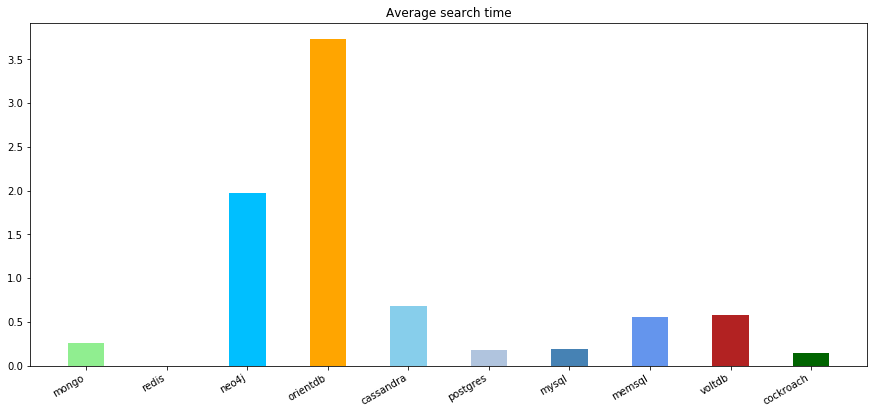

In [19]:
bar_plot(unindexed_read_times_avg, containers, colours, "Average search time")

### Indexed Search Commands

In [20]:
indexed_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({Id:{{id}}}).pretty().shellPrint()" """,
    r"""docker exec --privileged redis sh -c "echo GET {{id}}} | redis-cli" """,
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n) WHERE ID(n) = {{id}}} RETURN n;\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select from Customer where Id = {{id}}}" """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select * from customers where id = {{id}}} allow filtering;" """,
    r"""docker exec --privileged postgres sh -c "echo \"SELECT * FROM customers where id = {{id}}}\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "SELECT * FROM customers where id = {{id}}}" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "SELECT * FROM customers where id = {{id}}}" """,
    r"""docker exec --privileged voltdb sh -c "echo \"SELECT * FROM customers where id = {{id}}}\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; SELECT * FROM customers where id = {{id}}};" """ 
]

#### Iterating

In [21]:
(indexed_read_times_avg, indexed_read_times_peak) = average_time2(indexed_read_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.2610602378845215
redis: 0.34110355377197266
neo4j: 1.4860024452209473
orientdb: 2.6303131580352783
cassandra: 0.6180005073547363
postgres: 0.20868349075317383
mysql: 0.1540694236755371
memsql: 0.2983689308166504
voltdb: 0.5526065826416016
cockroach: 0.17835760116577148


### Results

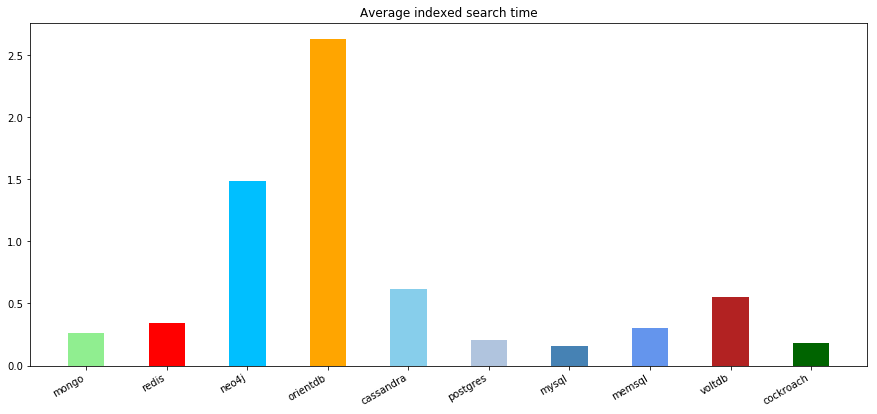

In [22]:
bar_plot(indexed_read_times_avg, containers, colours, "Average indexed search time")

### Aggregate Functions Commands

In [23]:
aggregate_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval 'db.customers.aggregate(    [      { $group: { "_id": "$first_name", "avg": { $avg: "$income" } } }    ] ).pretty().shellPrint();' """,
    r"""docker exec --privileged redis sh -c "echo zcount mylist -inf +inf | redis-cli" """,
    r"""docker exec --privileged neo4j sh -c "echo \"match (n:Customer) return avg(n.income);\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select avg(income) FROM Customer" """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select avg(income) as avg_income from customers;" """,
    r"""docker exec --privileged postgres sh -c "echo \"select avg(income) as avg_income from customers\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "select avg(income) as avg_income from customers" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "select avg(income) as avg_income from customers" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select avg(income) as avg_income from customers\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; select avg(income) as avg_income from customers;" """ 
]

#### Iterating

In [24]:
(aggregate_read_times_avg, aggregate_read_times_peak) = average_time2(aggregate_read_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.3500034809112549
redis: 0.18399977684020996
neo4j: 2.1082656383514404
orientdb: 3.933286428451538
cassandra: 1.2860004901885986
postgres: 0.19020628929138184
mysql: 0.1783127784729004
memsql: 0.6004183292388916
voltdb: 0.5440230369567871
cockroach: 0.15413928031921387


### Results

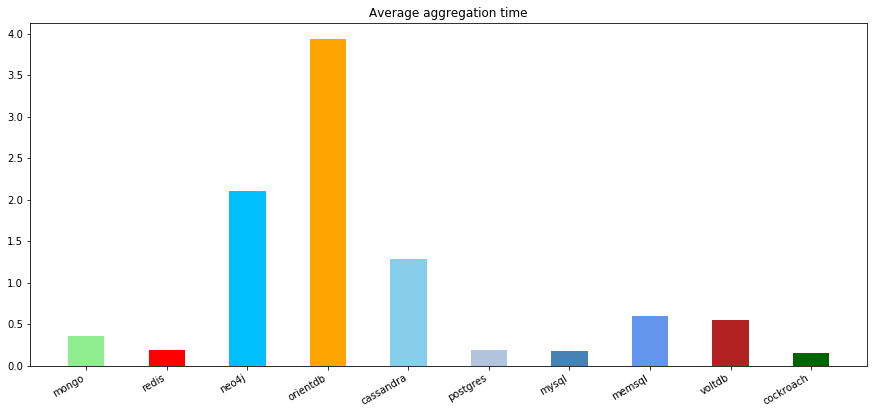

In [25]:
bar_plot(aggregate_read_times_avg, containers, colours, "Average aggregation time")

### Join Commands
MongoDB, Redis, OrientDB, Cassandra do not allow join operations.

In [26]:
join_commands = [
    "",
    "",
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n:Customer)-[:Autoedge]->(m:Customer) WHERE n.firstName = m.firstName RETURN n, m;\" | /var/lib/neo4j/bin/cypher-shell" """,
    "",
    "",
    r"""docker exec --privileged postgres sh -c "psql -q -U postgres mock -c 'select * from customers a, customers b where a.first_name = b.first_name;' > join.txt" """,
    r"""docker exec --privileged mysql sh -c "mysql -u root --password=password --database mock -e 'select * from customers a, customers b where a.first_name = b.first_name;' > join.txt " """,
    r"""docker exec --privileged memsql sh -c "memsql-shell --database mock -e 'select * from customers a, customers b where a.first_name = b.first_name;' > join.txt" """,
    r"""docker exec --privileged voltdb sh -c "echo 'select * from customers a, customers b where a.first_name = b.first_name;' | sqlcmd > join.txt"  """,
    r"""docker exec --privileged cockroach sh -c "./cockroach sql --insecure --execute='SET DATABASE = mock; select * from customers a, customers b where a.first_name = b.first_name;' > join.txt" """ 
]

#### Iterating

In [27]:
(join_times_avg, join_times_peak) = average_time2(join_commands, containers, num_of_runs)
join_times_avg[0] = 0; # mongodb does not support relational join operation
join_times_avg[1] = 0; # redis does not support relational join operation
join_times_avg[3] = 0; # orientdb does not support relational join operation
join_times_avg[4] = 0; # cassandra does not support relational join operation

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.011010408401489258
redis: 0.0069980621337890625
neo4j: 1.2839999198913574
orientdb: 0.005999565124511719
cassandra: 0.006000518798828125
postgres: 0.7616000175476074
mysql: 12.465137004852295
memsql: 1.2773466110229492
voltdb: 6.6590189933776855
cockroach: 0.17409968376159668


### Results

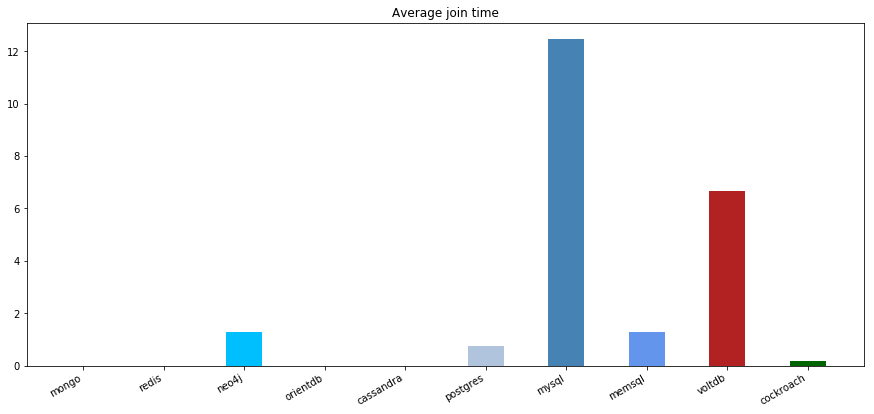

In [28]:
bar_plot(join_times_avg, containers, colours, "Average join time")

## Throughput

In [29]:
def read_throughput(commands, containers, iterations=100, verbose=True, import_data=True):
    times = [0] * len(containers)
    ratios = [0] * len(containers)
    _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
    time.sleep(25) 
    for i in range(0, len(containers)):
        #imports
        if verbose:
            print(containers[i])
            
        coackroach_ip = ""
        
        app1 = data_import_commands[i]
        app2 = commands[i]
        
        if containers[i] == "cockroach":
            ip = run_command('docker exec cockroach ip route', verbose=False)
            ip = ip[len(ip)-2].split(" ")
            ip = ip[len(ip)-2]
            cockroach_ip = ip
            data_import_commands[i][1] = data_import_commands[i][1].replace("{{cockroach_ip}}", cockroach_ip)
        if import_data:
            if containers[i] == "redis":
                exec_and_time2("redis", r"""docker exec --privileged redis sh -c "cat /shared_data/mock_data_10000_set.csv | redis-cli --pipe" """, verbose=False, save_mem=True)
            else: 
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
        if containers[i] == "neo4j":
            exec_and_time2("neo4j", r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n:Customer) CREATE (n)-[r:Autoedge]->(n) RETURN r;\" | /var/lib/neo4j/bin/cypher-shell" """, verbose=False, save_mem=True)
        #queries
        start = time.time()
        for j in range(0, iterations):  
            _ = exec_and_time2(containers[i], commands[i].replace("{{id}}", str(random.randrange(0, 9999, 1))), verbose=False, save_mem=True)
        
        data_import_commands[i] = app1
        commands[i] = app2
        
        end = time.time()
        times[i] = end - start
        ratios[i] = iterations/times[i]
    _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        print(containers[i] + ": " + str(ratios[i]))
    return ratios

In [30]:
indexed_read_throughput = read_throughput(indexed_read_commands, containers, 5)

mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 3.127886690710522
redis: 6.31311946945945
neo4j: 1.3316577378406775
orientdb: 0.4103236682992921
cassandra: 1.8575111438162117
postgres: 6.802823567269274
mysql: 7.618693327133225
memsql: 6.055441532986915
voltdb: 1.5387944371733464
cockroach: 7.539901596495296


### Results

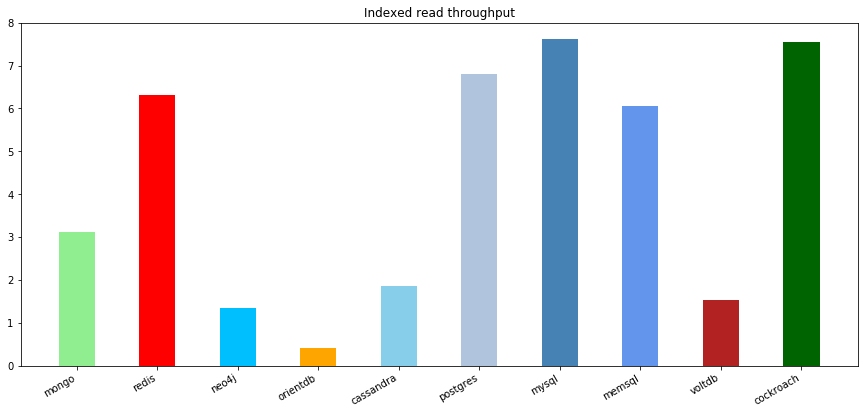

In [31]:
bar_plot(indexed_read_throughput, containers, colours, "Indexed read throughput")

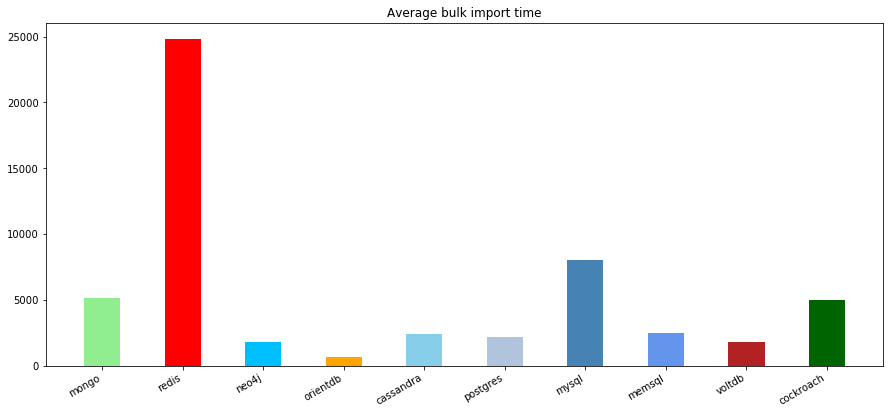

In [33]:
write_throughput = [10000/x for x in import_times_avg]

bar_plot(write_throughput, containers, colours, "Average bulk import time")